In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define elementary charge (Coulombs)
e = 1.60219e-19
#Sample width (meters)
d = 1.25e-3
#Sample length (meters)
s = 1e-2

temperature_room = 296.15  # K

voltage_error = 0.5E-7
current_error = 0.5E-7
magnetic_error = 0.5E-7
depth_error = 0.01E-3

In [41]:
from scipy.optimize import curve_fit

def exponential_func(x, a, b):
    return a * np.exp(b * x)

def r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_mean)**2)
    ss_res = np.sum((y_true - y_pred)**2)
    return 1 - (ss_res / ss_total)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def chi_squared(y_true, y_pred, sigma):
    return np.sum(((y_true - y_pred) / sigma)**2)

# Define a function to calculate Z-scores
def z_score(data):
    return np.abs((data - np.mean(data)) / np.std(data))


In [61]:
file_paths = [
    'SHE/data/suprav-elias-1e-4.txt',
    'SHE/data/suprav-elias-50e-6.txt',
    'SHE/data/suprav-elias-25e-6.txt',
    'SHE/data/suprav-elias-1e-5.txt',
    #'SHE/data/suprav-elias-1e-6.txt'
]

# Initialize an empty list to store the datasets
combined_data = []

for file_path in file_paths:
    # Read data from file
    data = np.genfromtxt(file_path, skip_header=1)
    
    # Find and remove data points outside the temperature range
    indices_to_remove = []
    for i in range(1, len(data)-1):
        if not data[i-1, 0] <= data[i, 0] <= data[i+1, 0]:
            indices_to_remove.append(i)
    data = np.delete(data, indices_to_remove, axis=0)

    # Interpolate the missing data
    mask = ~np.isnan(data[:, 0])
    x = np.arange(len(data))
    data[:, 1:] = np.array([np.interp(x, x[mask], data[mask, i]) for i in range(1, data.shape[1])]).T

    # Append the processed data to the combined_data list
    combined_data.append(data)

# Combine all datasets
combined_data = np.vstack(combined_data)
combined_data = combined_data[combined_data[:, 0].argsort()]

# Scaling to Tesla
b_field = combined_data[:, 1] / 10000

print(len(b_field))

# Define cutoffs for low, high positive, and high negative B-field
low_b_cutoff = 100 / 10000
high_positive_b_cutoff = 1000 / 10000
high_negative_b_cutoff = -1000 / 10000

# Separate data into three B-field regions
low_b_mask = (abs(b_field) < low_b_cutoff)
high_positive_b_mask = (b_field > high_positive_b_cutoff)
high_negative_b_mask = (b_field < high_negative_b_cutoff)

# Extract relevant columns
temperature = combined_data[:, 0]
idx_room_temp = np.argmin(np.abs(temperature - temperature_room))


current_ab, current_ad, current_ac, current_bd, ncurrent_ab, ncurrent_ad, ncurrent_ac, ncurrent_bd = combined_data[:, 2:10].T
vdc, vbc, Vhbd, Vhac, nvdc, nvbc, nVhbd, nVhac = combined_data[:, 10:].T

def calculate_transR(voltage, current):
    R = voltage/current
    delta_R = np.abs(R) * np.sqrt( np.power(voltage_error/voltage,2) +  np.power(current_error/current,2))
    return R, delta_R

R_ABDC = calculate_transR(vdc, current_ab)

R_ADBC = calculate_transR(vbc, current_ad)

nR_ABDC = calculate_transR(nvdc, ncurrent_ab)

nR_ADBC = calculate_transR(nvbc, ncurrent_ad)

R_ACBD = calculate_transR(Vhbd, current_ac)
R_BDAC = calculate_transR(Vhac, current_bd)
nR_ACBD = calculate_transR(nVhbd, ncurrent_ac)
nR_BDAC = calculate_transR(nVhac, ncurrent_bd)

def calculate_hall_coefficient(mask):
    avg_R = (R_ACBD[0] + R_BDAC[0])/2
    daR = np.sqrt((R_ACBD[1]/2)**2+(R_BDAC[1]/2)**2)
    navg_R = (nR_ACBD[0] + nR_BDAC[0])/2
    dnaR = np.sqrt((nR_ACBD[1]/2)**2+(nR_BDAC[1]/2)**2)
    R_avg = (avg_R+navg_R)/2
    delta_R_avg = np.sqrt((daR/2)**2+(dnaR/2)**2)
                          
    hall_coef = (d*R_avg) / b_field
    error = np.abs(hall_coef) * np.sqrt( np.power(depth_error/d,2) + np.power(delta_R_avg/R_avg,2) + np.power(magnetic_error/b_field,2) )
    
    return hall_coef[mask], error[mask]

def extrinsic_carriers(mask):
    avg_R = (R_ACBD[0] + R_BDAC[0])/2
    daR = np.sqrt((R_ACBD[1]/2)**2+(R_BDAC[1]/2)**2)
    navg_R = (nR_ACBD[0] + nR_BDAC[0])/2
    dnaR = np.sqrt((nR_ACBD[1]/2)**2+(nR_BDAC[1]/2)**2)

    p_pdata = 1/ avg_R
    p_perr = daR/avg_R**2
    p_ndata = 1/ navg_R
    p_nerr = dnaR/navg_R**2

    avg_carriers = abs(b_field * (p_pdata+p_ndata)/2 / e / d)
    error = abs(avg_carriers)*np.sqrt(np.power(depth_error/d,2)+np.power(2*np.sqrt((p_perr/2)**2+(p_nerr/2)**2)/(p_pdata+p_ndata),2)+np.power(magnetic_error/b_field,2))
    return avg_carriers[mask], error[mask]

def calculate_resistivity(mask):
    R_adj1 = (R_ABDC[0] + nR_ABDC[0])/2
    R_adj2 = (R_ADBC[0] + nR_ADBC[0])/2
    delta_R_adj1 = np.sqrt( np.power(R_ABDC[1],2) + np.power(nR_ABDC[1],2) )/2
    delta_R_adj2 = np.sqrt( np.power(R_ADBC[1],2) + np.power(nR_ADBC[1],2) )/2

    def f(x):
        return 1/np.cosh(np.log(x)/2.403)
    
    def delta_f(x, delta_x):
        const = 0.416146
        return np.abs( -const * np.tanh(const*x) * 1/np.cosh(const*x) ) * delta_x
    
    x = R_adj1/R_adj2
    delta_x = np.abs(x) * np.sqrt( np.power(delta_R_adj1/R_adj1,2) + np.power(delta_R_adj2/R_adj2,2) )
    shape_factor = f(x)
    shape_error = delta_f(x, delta_x)
    
    R_avg = (R_adj1 + R_adj2)/2
    delta_R_avg = np.sqrt( np.power(delta_R_adj1,2) + np.power(delta_R_adj2,2) )/2
    
    resistivity = (np.pi*d/np.log(2)) * (R_adj1+R_adj2)/2 * f(R_adj1/R_adj2)
    error = np.abs(resistivity) * np.sqrt( np.power(depth_error/d,2) + np.power(delta_R_avg/R_avg,2) + np.power(shape_error/shape_factor,2) )
    
    return resistivity[mask], error[mask]

def calculate_conductivity(mask):
    rho = calculate_resistivity(mask)
    sig = 1/rho[0]
    delta_sig = rho[1]/np.power(rho[0],2)
    return sig, delta_sig

inv_temperature = 1000/temperature 
# Calculate inverse temperature for each region
inv_temperature_low_b = inv_temperature[low_b_mask]
inv_temperature_high_positive_b = inv_temperature[high_positive_b_mask]
inv_temperature_high_negative_b = inv_temperature[high_negative_b_mask]

# Calculate resistivity for each region
Rh_low_b = calculate_hall_coefficient(low_b_mask)
Rh_high_positive_b = calculate_hall_coefficient(high_positive_b_mask)
Rh_high_negative_b = calculate_hall_coefficient(high_negative_b_mask)

# Calculate resistivity for each region
rho_low_b = calculate_resistivity(low_b_mask)
rho_high_positive_b = calculate_resistivity(high_positive_b_mask)
rho_high_negative_b = calculate_resistivity(high_negative_b_mask)

# Calculate conductivity for each region
sig_low_b = calculate_conductivity(low_b_mask)
sig_high_pb = calculate_conductivity(high_positive_b_mask)
sig_high_nb = calculate_conductivity(high_negative_b_mask)

669


Q1: rho and R_H at roomtemp: 0.9201220559689709 +- 0.007739401664558373,-0.11151067839195979+-0.0009716480146425703
Q1: -8.25142550684468 +- -0.09993243562791304 G
Q2: Extrinsic from  0-244.75 K and intrisic thereafter.


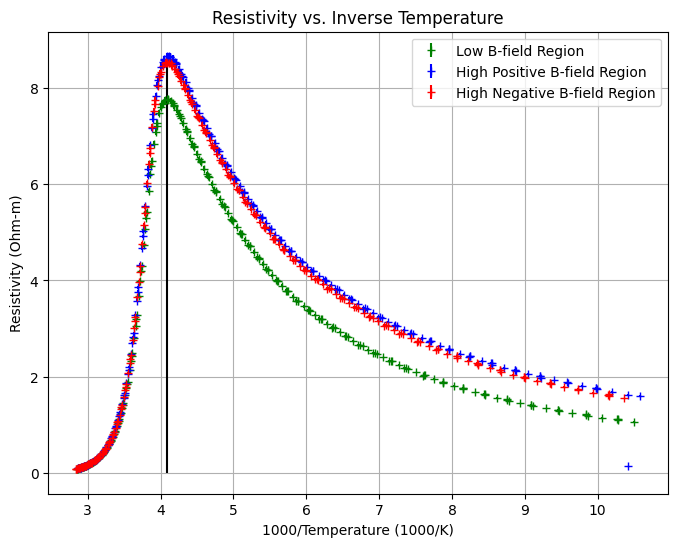

In [89]:
#QUESTION 1: For Resistivity and Hall Coefficient of the sample at room temperature. 
# At what magnetic field intensity, would the E field due to Hall effect be of the 
# same magnitude (though perpendicular in direction) as the E field due to resistance?

#SOLVE B=rho/R_H at room temp
print(f'Q1: rho and R_H at roomtemp: {rho_high_positive_b[0][int(idx_room_temp/3)]} +- {rho_high_positive_b[1][int(idx_room_temp/3)]},{Rh_high_positive_b[0][int(idx_room_temp/3)]}+-{Rh_high_positive_b[1][int(idx_room_temp/3)]}')
print(f'Q1: {rho_high_positive_b[0][int(idx_room_temp/3)]/Rh_high_positive_b[0][int(idx_room_temp/3)]} +- {(rho_high_positive_b[0][int(idx_room_temp/3)]/Rh_high_positive_b[0][int(idx_room_temp/3)])*np.sqrt((rho_high_positive_b[1][int(idx_room_temp/3)]/rho_high_positive_b[0][int(idx_room_temp/3)])**2 + (Rh_high_positive_b[1][int(idx_room_temp/3)]/Rh_high_positive_b[0][int(idx_room_temp/3)])**2 )} G')

#QUESTION 2:
# Plot resistivity versus inverse temperature for each region

# Calc max rho for all data
idx_max_rho_full = np.argmax(calculate_resistivity((abs(b_field)>0))[0])

print(f'Q2: Extrinsic from  0-{temperature[idx_max_rho_full]} K and intrisic thereafter.')


plt.figure(figsize=(8, 6))
plt.errorbar(inv_temperature_low_b, rho_low_b[0], yerr=rho_low_b[1], fmt='g+', label='Low B-field Region')
plt.errorbar(inv_temperature_high_positive_b, rho_high_positive_b[0], yerr=rho_high_positive_b[1], fmt='b+', label='High Positive B-field Region')
plt.errorbar(inv_temperature_high_negative_b, rho_high_negative_b[0], yerr=rho_high_negative_b[1], fmt='r+',label='High Negative B-field Region')
plt.vlines(1000/temperature[idx_max_rho_full], 0,8.5, colors='black')
plt.xlabel('1000/Temperature (1000/K)')
plt.ylabel('Resistivity (Ohm-m)')
plt.title('Resistivity vs. Inverse Temperature')
plt.grid()
plt.legend()
plt.savefig('resistivity_plot.png', format='png')
plt.show()

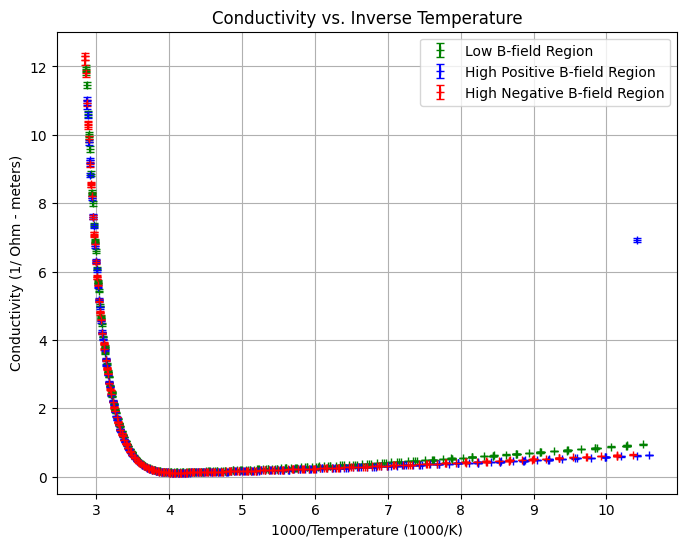

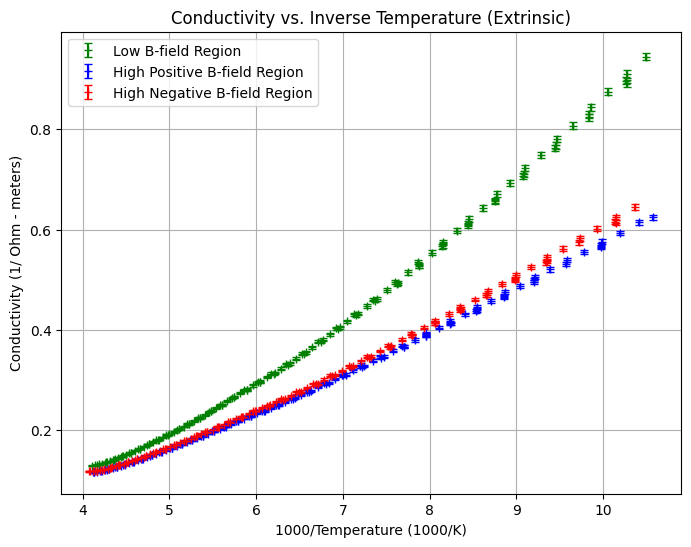

In [44]:
#QUESTION 3:
plt.figure(figsize=(8, 6))
plt.errorbar(inv_temperature_low_b, sig_low_b[0], yerr=sig_low_b[1], fmt='g+', label='Low B-field Region', capsize=3)
plt.errorbar(inv_temperature_high_positive_b, sig_high_pb[0], yerr=sig_high_pb[1], fmt='b+', label='High Positive B-field Region', capsize=3)
plt.errorbar(inv_temperature_high_negative_b, sig_high_nb[0], yerr=sig_high_nb[1], fmt='r+', label='High Negative B-field Region', capsize=3)
plt.xlabel('1000/Temperature (1000/K)')
plt.ylabel('Conductivity (1/ Ohm - meters)')
plt.title('Conductivity vs. Inverse Temperature')
plt.grid()
plt.legend()
plt.savefig('conductivity_plot.png', format='png')
plt.show()

# Assuming 1:1:1 measurements for 0B, +B, -B
idx_max_rho = int(idx_max_rho_full / 3)

# Calculate Z-scores for mobility
z_scores_zero = z_score(sig_low_b[0][:idx_max_rho])
z_scores_positive = z_score(sig_high_pb[0][:idx_max_rho])
z_scores_negative = z_score(sig_high_nb[0][:idx_max_rho])

# Define a threshold for outliers (e.g., z_score > 3 for significant outliers)
threshold = 3

# Filter out outlier data points
# Define the temperature and Hall coefficient times conductivity data
filtered_inv_temperature_low = inv_temperature_low_b[:idx_max_rho][z_scores_zero <= threshold]
filtered_inv_temperature_positive = inv_temperature_high_positive_b[:idx_max_rho][z_scores_positive <= threshold]
filtered_inv_temperature_negative = inv_temperature_high_negative_b[:idx_max_rho][z_scores_negative <= threshold]
data_zero = sig_low_b[0][:idx_max_rho][z_scores_zero <= threshold]
data_positive = sig_high_pb[0][:idx_max_rho][z_scores_positive <= threshold]
data_negative = sig_high_nb[0][:idx_max_rho][z_scores_negative <= threshold]
error_zero = sig_low_b[1][:idx_max_rho][z_scores_zero <= threshold]
error_positive = sig_high_pb[1][:idx_max_rho][z_scores_positive <= threshold]
error_negative = sig_high_nb[1][:idx_max_rho][z_scores_negative <= threshold]


plt.figure(figsize=(8, 6))
plt.errorbar(filtered_inv_temperature_low, data_zero, yerr=error_zero, fmt='g+', label='Low B-field Region', capsize=3)
plt.errorbar(filtered_inv_temperature_positive, data_positive, yerr=error_positive, fmt='b+', label='High Positive B-field Region', capsize=3)
plt.errorbar(filtered_inv_temperature_negative, data_negative, yerr=error_negative, fmt='r+', label='High Negative B-field Region', capsize=3)
plt.xlabel('1000/Temperature (1000/K)')
plt.ylabel('Conductivity (1/ Ohm - meters)')
plt.title('Conductivity vs. Inverse Temperature (Extrinsic)')
plt.grid()
plt.legend()
plt.savefig('conductivity_plot_extrinsic.png', format='png')
plt.show()

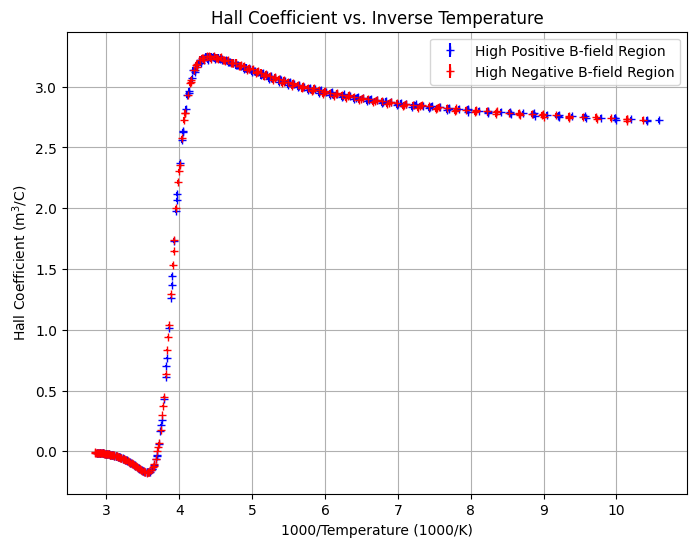

Charge carrier concentration at room temperature: 5.597183243549743e+19+-4.877104206172508e+17
Mobility of charge carriers at room temperature: 0.1211911807445253+--0.0016015161833997
Hall Coefficient becomes 0 at 270.75 K


In [74]:
#QUESTION 4:
plt.figure(figsize=(8, 6))
plt.errorbar(inv_temperature_high_positive_b, Rh_high_positive_b[0], yerr= Rh_high_positive_b[1],fmt='b+',label='High Positive B-field Region')
plt.errorbar(inv_temperature_high_negative_b, Rh_high_negative_b[0], yerr=Rh_high_negative_b[1], fmt='r+',label='High Negative B-field Region')
plt.xlabel('1000/Temperature (1000/K)')
plt.ylabel('Hall Coefficient ('+r"m$^3$/C"+')')
plt.title('Hall Coefficient vs. Inverse Temperature')
plt.grid()
plt.legend()
plt.savefig('hall_coef_plot.png', format='png')
plt.show()

#QUESTION 5:
print(f'Charge carrier concentration at room temperature: {-1/e/Rh_high_positive_b[0][int(idx_room_temp/3)]}+-{1/e*Rh_high_positive_b[1][int(idx_room_temp/3)]/(Rh_high_positive_b[0][int(idx_room_temp/3)])**2}')
print(f'Mobility of charge carriers at room temperature: {-Rh_high_positive_b[0][int(idx_room_temp/3)]*sig_high_pb[0][int(idx_room_temp/3)]}+-{Rh_high_positive_b[0][int(idx_room_temp/3)]*sig_high_pb[0][int(idx_room_temp/3)]*np.sqrt((Rh_high_positive_b[1][int(idx_room_temp/3)]/Rh_high_positive_b[0][int(idx_room_temp/3)])**2+(sig_high_pb[1][int(idx_room_temp/3)]*sig_high_pb[0][int(idx_room_temp/3)])**2)}')
#print(f'Room Temp:{temperature[high_positive_b_mask][[int(idx_room_temp/3)]]}')

temperature_positive = temperature[high_positive_b_mask]
temperature_negative = temperature[high_negative_b_mask]

idx_zero_hall = np.argmin(Rh_high_positive_b[0][10:])
print(f'Hall Coefficient becomes 0 at {temperature_positive[155]} K')

In [73]:
Rh_high_positive_b[0][155:]

array([-0.02692326, -0.0413686 , -0.06304949, -0.11099473, -0.14451356,
       -0.14748368, -0.15122614, -0.16846306, -0.17362343, -0.17173381,
       -0.16904515, -0.1713999 , -0.16463679, -0.16116654, -0.15629711,
       -0.15290778, -0.14260191, -0.13888366, -0.1350424 , -0.12898896,
       -0.11849044, -0.11527359, -0.11151068, -0.10566813, -0.09641812,
       -0.09290914, -0.09074353, -0.08550188, -0.07773575, -0.0748996 ,
       -0.07312861, -0.06874059, -0.06229004, -0.05962287, -0.0586536 ,
       -0.05499843, -0.05006448, -0.04786073, -0.04704377, -0.04416552,
       -0.04025777, -0.03848519, -0.03797111, -0.03567329, -0.03238708,
       -0.03100527, -0.03064541, -0.02874373, -0.02617797, -0.02503764,
       -0.02463263, -0.02333636, -0.02126714, -0.02038153, -0.01999341,
       -0.01893977, -0.017366  , -0.01635605, -0.0165395 , -0.01549172,
       -0.01424887, -0.01369541, -0.01377638, -0.01270546, -0.01168553,
       -0.01140075, -0.01118223])

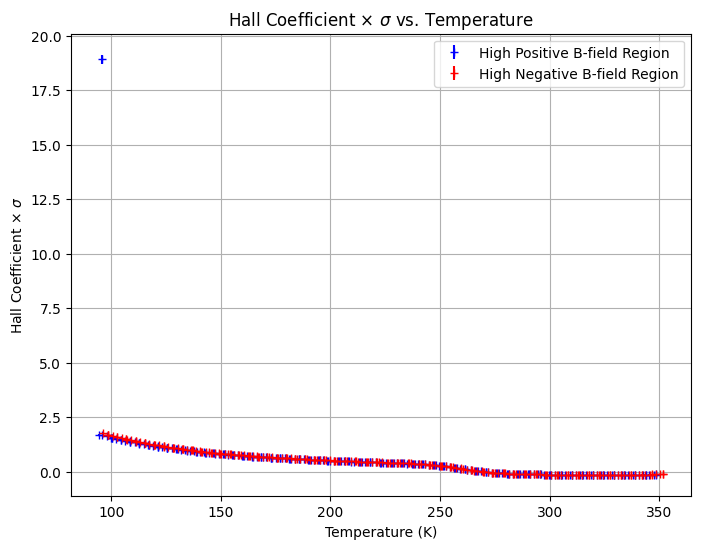

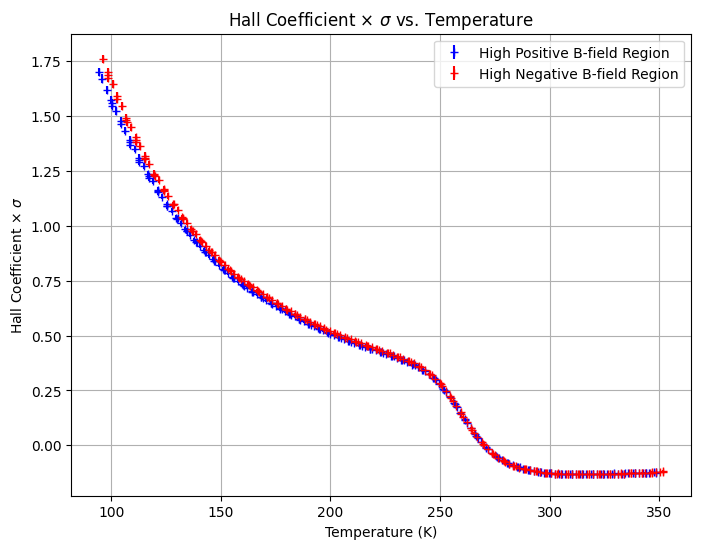

Positive Region Fit Coefficients (3rd order poly): [-1.15980385e-06  1.12546620e-03 -3.63329265e-01  3.88899573e+01]
Negative Region Fit Coefficients: [-1.15236171e-06  1.12125355e-03 -3.62835677e-01  3.89191064e+01]
Positive Region R-squared: 0.9952
Positive Region RMSE: 0.0091
Negative Region R-squared: 0.9951
Negative Region RMSE: 0.0090
Positive Region Chi-squared: 22966.6424
Negative Region Chi-squared: 14956.5162


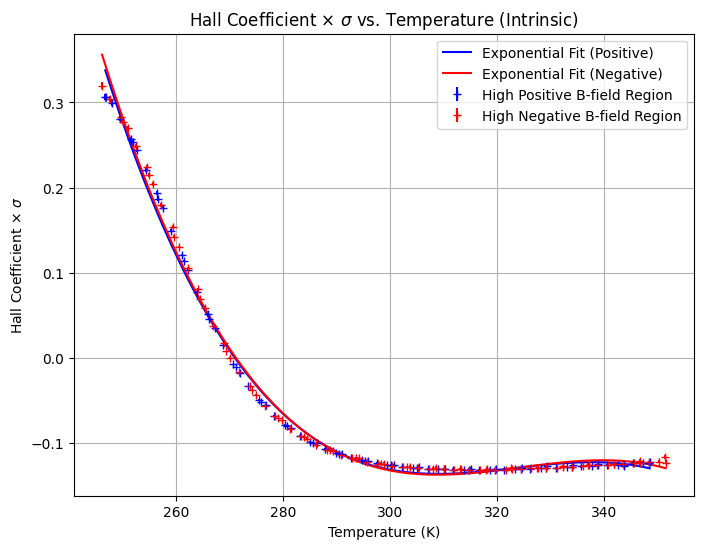

Hall Coefficient becomes 0 at 174.82 K
Extrisic carriers 2.1083891516238205e+18+-1.7121154444929582e+16
Positive Region Fit Coefficients: [ 4.59416989 -0.0111961 ]
Negative Region Fit Coefficients: [ 4.96357708 -0.01149463]
Positive Region R-squared: 0.9952
Positive Region RMSE: 0.0091
Negative Region R-squared: 0.9951
Negative Region RMSE: 0.0090
Positive Region Chi-squared: 3730.9302
Negative Region Chi-squared: 4319.9911


/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_70146/925460626.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * x)
/var/folders/8g/g48bxxwn3139k68mrwrpq2xw0000gn/T/ipykernel_70146/925460626.py:4: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(b * x)


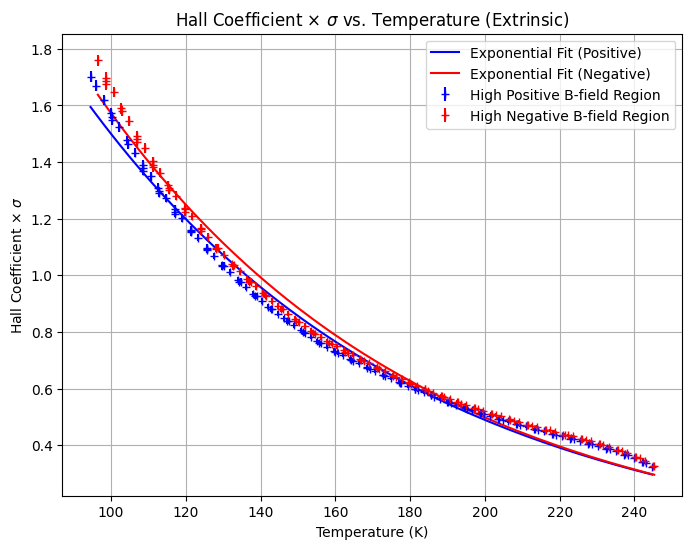

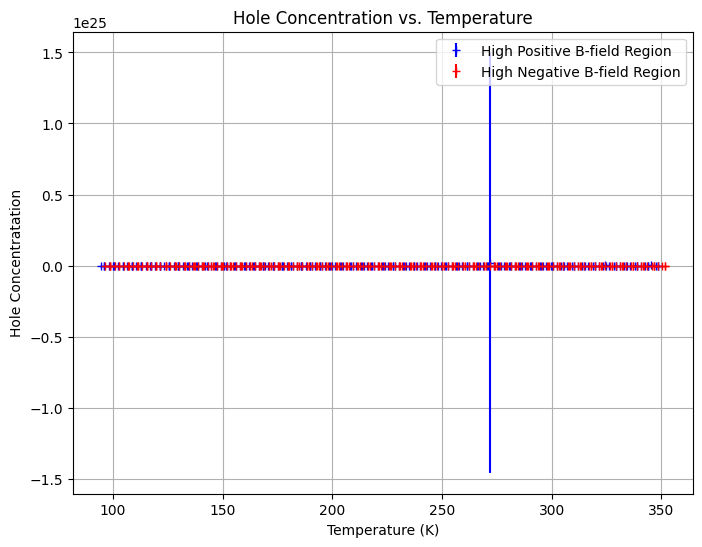

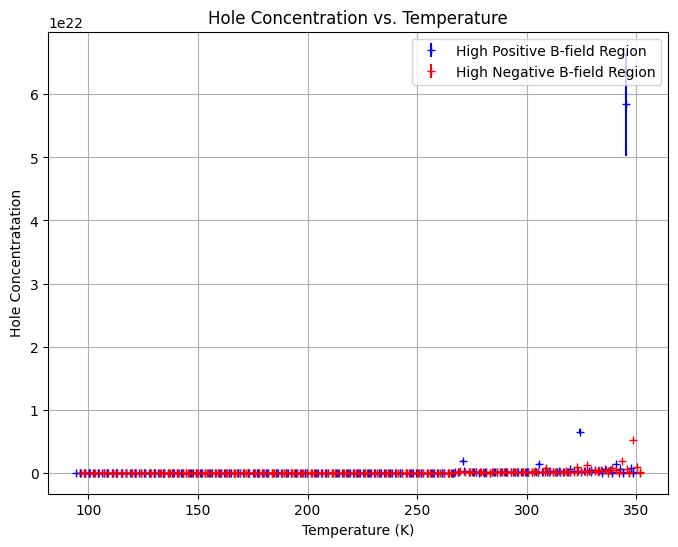

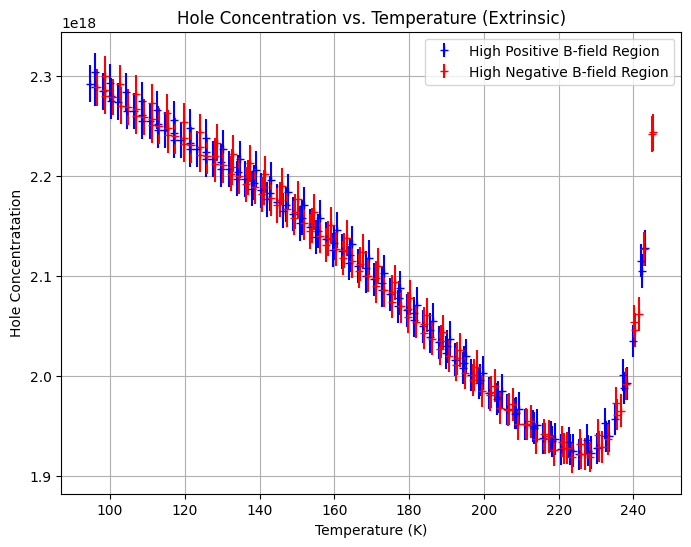

Positive Region Fit Coefficients (m, c): 0.039916480530733385 33.65725249275745
Negative Region Fit Coefficients (m, c): 0.03637879093651968 34.46082223917761


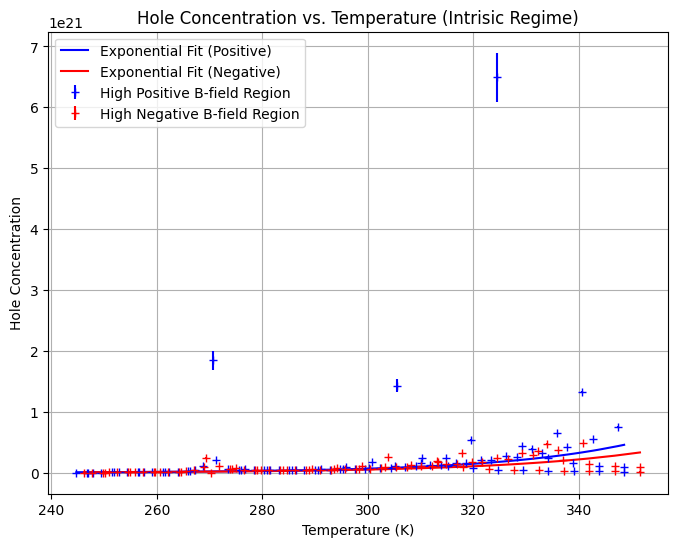

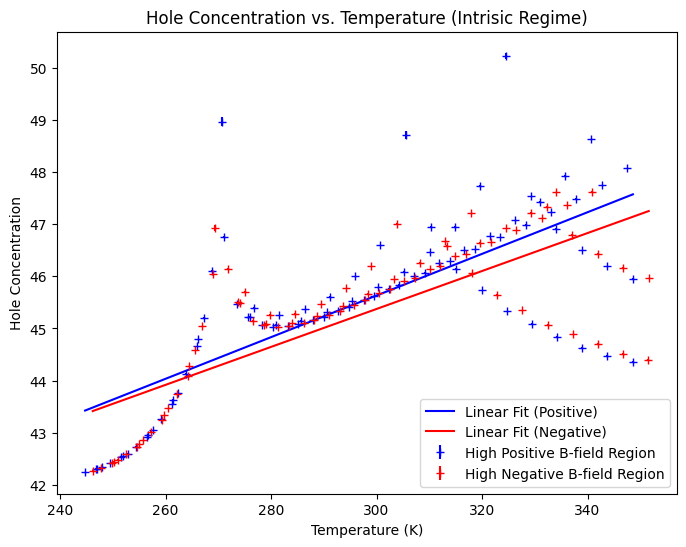

In [101]:
temperature_positive = temperature[high_positive_b_mask]
temperature_negative = temperature[high_negative_b_mask]

#QUESTION 6:
plt.figure(figsize=(8, 6))
plt.errorbar(temperature_positive, Rh_high_positive_b[0]*sig_high_pb[0], yerr= np.abs(Rh_high_positive_b[0]*sig_high_pb[0])*np.sqrt((Rh_high_positive_b[1]/Rh_high_positive_b[0])**2+(sig_high_pb[1]/sig_high_pb[0])**2), fmt='b+',label='High Positive B-field Region')
plt.errorbar(temperature_negative, Rh_high_negative_b[0]*sig_high_nb[0], yerr= np.abs(Rh_high_negative_b[0]*sig_high_nb[0])*np.sqrt((Rh_high_negative_b[1]/Rh_high_negative_b[0])**2+(sig_high_nb[1]/sig_high_nb[0])**2), fmt='r+',label='High Negative B-field Region')
plt.xlabel('Temperature (K)')
plt.ylabel('Hall Coefficient'+r" $ \times \ \sigma$")
plt.title('Hall Coefficient' +r" $\times \ \sigma$"+  ' vs. Temperature')
plt.grid()
plt.legend()
plt.savefig('mobility_plot.png', format='png')
plt.show()

# Calculate Z-scores for mobility
z_scores_positive = z_score(Rh_high_positive_b[0]*sig_high_pb[0])
z_scores_negative = z_score(Rh_high_negative_b[0]*sig_high_nb[0])

# Define a threshold for outliers (e.g., z_score > 3 for significant outliers)
threshold = 3

# Filter out outlier data points
# Define the temperature and Hall coefficient times conductivity data
filtered_temperature_positive = temperature[high_positive_b_mask][z_scores_positive <= threshold]
filtered_temperature_negative = temperature[high_negative_b_mask][z_scores_negative <= threshold]
data_positive = (Rh_high_positive_b[0] * sig_high_pb[0])[z_scores_positive <= threshold]
data_negative = (Rh_high_negative_b[0] * sig_high_nb[0])[z_scores_negative <= threshold]
error_positive = (np.abs(Rh_high_positive_b[0]*sig_high_pb[0])*np.sqrt((Rh_high_positive_b[1]/Rh_high_positive_b[0])**2
             +(sig_high_pb[1]/sig_high_pb[0])**2))[z_scores_positive <= threshold]
error_negative = (np.abs(Rh_high_negative_b[0]*sig_high_nb[0])*np.sqrt((Rh_high_negative_b[1]/Rh_high_negative_b[0])**2
            +(sig_high_nb[1]/sig_high_nb[0])**2))[z_scores_negative <= threshold]


plt.figure(figsize=(8, 6))
plt.errorbar(filtered_temperature_positive, data_positive, 
             yerr= error_positive, fmt='b+',label='High Positive B-field Region')
plt.errorbar(filtered_temperature_negative, data_negative, 
             yerr= error_negative, fmt='r+',label='High Negative B-field Region')
plt.xlabel('Temperature (K)')
plt.ylabel('Hall Coefficient'+r" $ \times \ \sigma$")
plt.title('Hall Coefficient' +r" $\times \ \sigma$"+  ' vs. Temperature')
plt.grid()
plt.legend()
plt.savefig('mobility_plot_w_cut.png', format='png')
plt.show()

idx_zero_hall = np.argmin(np.abs(Rh_high_positive_b[0]))

# Fit polynomial curves
params_positive = np.polyfit(filtered_temperature_positive[idx_max_rho:], data_positive[idx_max_rho:], 3)
params_negative = np.polyfit(filtered_temperature_negative[idx_max_rho:], data_negative[idx_max_rho:], 3)

# Generate points for the polynomial fits
fit_line_positive = np.polyval(params_positive, filtered_temperature_positive)
fit_line_negative = np.polyval(params_negative, filtered_temperature_negative)

# Print coefficients
print("Positive Region Fit Coefficients (3rd order poly):", params_positive)
print("Negative Region Fit Coefficients:", params_negative)

# Calculate R-squared
r_squared_positive = r_squared(data_positive[idx_max_rho:], fit_line_positive[idx_max_rho:])
r_squared_negative = r_squared(data_negative[idx_max_rho:], fit_line_negative[idx_max_rho:])

# Calculate RMSE
rmse_positive = rmse(data_positive[idx_max_rho:], fit_line_positive[idx_max_rho:])
rmse_negative = rmse(data_negative[idx_max_rho:], fit_line_negative[idx_max_rho:])

# Print the goodness of fit metrics
print(f"Positive Region R-squared: {r_squared_positive:.4f}")
print(f"Positive Region RMSE: {rmse_positive:.4f}")
print(f"Negative Region R-squared: {r_squared_negative:.4f}")
print(f"Negative Region RMSE: {rmse_negative:.4f}")

sigma_positive = error_positive[idx_max_rho:]
sigma_negative = error_negative[idx_max_rho:]

chi_squared_positive = chi_squared(data_positive[idx_max_rho:], fit_line_positive[idx_max_rho:], sigma_positive)
chi_squared_negative = chi_squared(data_negative[idx_max_rho:], fit_line_negative[idx_max_rho:], sigma_negative)

# Print the chi-squared values
print(f"Positive Region Chi-squared: {chi_squared_positive:.4f}")
print(f"Negative Region Chi-squared: {chi_squared_negative:.4f}")

# Plot the data and the exponential fits
plt.figure(figsize=(8, 6))
#plt.plot(temperature_positive[idx_max_rho:], data_positive[idx_max_rho:], 'b+', label='High Positive B-field Region')
#plt.plot(temperature_negative[idx_max_rho:], data_negative[idx_max_rho:], 'r+', label='High Negative B-field Region')

# Plot the exponential fits
plt.plot(filtered_temperature_positive[idx_max_rho:], fit_line_positive[idx_max_rho:], 'b-', label='Exponential Fit (Positive)')
plt.plot(filtered_temperature_negative[idx_max_rho:], fit_line_negative[idx_max_rho:], 'r-', label='Exponential Fit (Negative)')
plt.errorbar(filtered_temperature_positive[idx_max_rho:], data_positive[idx_max_rho:], 
             yerr= error_positive[idx_max_rho:], fmt='b+', label='High Positive B-field Region')
plt.errorbar(filtered_temperature_negative[idx_max_rho:], data_negative[idx_max_rho:], 
             yerr= error_negative[idx_max_rho:], fmt='r+', label='High Negative B-field Region')
plt.xlabel('Temperature (K)')
plt.ylabel('Hall Coefficient'+r" $ \times \ \sigma$")
plt.title('Hall Coefficient' +r" $\times \ \sigma$"+  ' vs. Temperature (Intrinsic)')
plt.legend()
plt.grid()
plt.savefig('mobility_plot_intrinsic.png', format='png')
plt.show()



print(f'Hall Coefficient becomes 0 at {temperature[idx_zero_hall]} K')
print(f'Extrisic carriers {np.average(extrinsic_carriers(high_positive_b_mask)[0][:idx_max_rho])}+-{np.average(extrinsic_carriers(high_positive_b_mask)[1][:idx_max_rho])}')

# Fit exponential curves
params_positive, _ = curve_fit(exponential_func, filtered_temperature_positive[:idx_max_rho], data_positive[:idx_max_rho], p0 = (1,-0.1))
params_negative, _ = curve_fit(exponential_func, filtered_temperature_negative[:idx_max_rho], data_negative[:idx_max_rho], p0 = (1,-0.1))

# Generate points for the exponential fits
fit_line_positive = exponential_func(filtered_temperature_positive[:idx_max_rho], *params_positive)
fit_line_negative = exponential_func(filtered_temperature_negative[:idx_max_rho], *params_negative)

# Print coefficients
print("Positive Region Fit Coefficients:", params_positive)
print("Negative Region Fit Coefficients:", params_negative)

# Print the goodness of fit metrics
print(f"Positive Region R-squared: {r_squared_positive:.4f}")
print(f"Positive Region RMSE: {rmse_positive:.4f}")
print(f"Negative Region R-squared: {r_squared_negative:.4f}")
print(f"Negative Region RMSE: {rmse_negative:.4f}")

sigma_positive = error_positive[:idx_max_rho]
sigma_negative = error_negative[:idx_max_rho]

chi_squared_positive = chi_squared(data_positive[:idx_max_rho], fit_line_positive[:idx_max_rho], sigma_positive)
chi_squared_negative = chi_squared(data_negative[:idx_max_rho], fit_line_negative[:idx_max_rho], sigma_negative)

# Print the chi-squared values
print(f"Positive Region Chi-squared: {chi_squared_positive:.4f}")
print(f"Negative Region Chi-squared: {chi_squared_negative:.4f}")

# Plot the data and the exponential fits
plt.figure(figsize=(8, 6))

# Plot the exponential fits
plt.plot(filtered_temperature_positive[:idx_max_rho], fit_line_positive[:idx_max_rho], 'b-', label='Exponential Fit (Positive)')
plt.plot(filtered_temperature_negative[:idx_max_rho], fit_line_negative[:idx_max_rho], 'r-', label='Exponential Fit (Negative)')

plt.errorbar(filtered_temperature_positive[:idx_max_rho], data_positive[:idx_max_rho], 
             yerr= error_positive[:idx_max_rho], fmt='b+', label='High Positive B-field Region')
plt.errorbar(filtered_temperature_negative[:idx_max_rho], data_negative[:idx_max_rho], 
             yerr= error_negative[:idx_max_rho], fmt='r+', label='High Negative B-field Region')
plt.xlabel('Temperature (K)')
plt.ylabel('Hall Coefficient'+r" $ \times \ \sigma$")
plt.title('Hall Coefficient' +r" $\times \ \sigma$"+  ' vs. Temperature (Extrinsic)')
plt.legend()
plt.grid()
plt.savefig('mobility_plot_extrinsic.png', format='png')
plt.show()


carriers_positive = extrinsic_carriers(high_positive_b_mask)
carriers_negative = extrinsic_carriers(high_negative_b_mask)

#QUESTION 8: Hole concentration vs temperature
plt.figure(figsize=(8, 6))
plt.errorbar(temperature_positive, carriers_positive[0], yerr = carriers_positive[1], fmt='b+', label='High Positive B-field Region')
plt.errorbar(temperature_negative, -carriers_negative[0], yerr = carriers_negative[1], fmt='r+', label='High Negative B-field Region')
plt.xlabel('Temperature (K)')
plt.ylabel('Hole Concentratation')
plt.title('Hole Concentration vs. Temperature')
plt.legend()
plt.grid()
plt.savefig('hole_concentration.png', format='png')
plt.show()


# Remove high error (dP>P)
error_mask_positive = carriers_positive[1]<np.abs(carriers_positive[0])
error_mask_negative = carriers_negative[1]<np.abs(carriers_negative[0])


plt.figure(figsize=(8, 6))
plt.errorbar(temperature_positive[error_mask_positive], carriers_positive[0][error_mask_positive], yerr = carriers_positive[1][error_mask_positive], fmt='b+', label='High Positive B-field Region')
plt.errorbar(temperature_negative[error_mask_negative], carriers_negative[0][error_mask_negative], yerr = carriers_negative[1][error_mask_negative], fmt='r+', label='High Negative B-field Region')
plt.xlabel('Temperature (K)')
plt.ylabel('Hole Concentratation')
plt.title('Hole Concentration vs. Temperature')
plt.legend()
plt.grid()
plt.savefig('filtered_hole_concentration.png', format='png')
plt.show()

plt.figure(figsize=(8, 6))
plt.errorbar(temperature_positive[error_mask_positive][:idx_max_rho], carriers_positive[0][error_mask_positive][:idx_max_rho], yerr = carriers_positive[1][error_mask_positive][:idx_max_rho], fmt='b+', label='High Positive B-field Region')
plt.errorbar(temperature_negative[error_mask_negative][:idx_max_rho], carriers_negative[0][error_mask_negative][:idx_max_rho], yerr = carriers_negative[1][error_mask_negative][:idx_max_rho], fmt='r+', label='High Negative B-field Region')
plt.xlabel('Temperature (K)')
plt.ylabel('Hole Concentratation')
plt.title('Hole Concentration vs. Temperature (Extrinsic)')
plt.legend()
plt.grid()
plt.savefig('hole_concentration_extrinsic.png', format='png')
plt.show()

# Extract relevant columns
temperature_positive = temperature[high_positive_b_mask]
carriers_positive = extrinsic_carriers(high_positive_b_mask)

temperature_negative = temperature[high_negative_b_mask]
carriers_negative = extrinsic_carriers(high_negative_b_mask)

# Remove negative values
# temperature_positive = temperature_positive[carriers_positive < 1e22]
# carriers_positive = carriers_positive[carriers_positive < 1e22]

# temperature_negative = temperature_negative[carriers_negative < 1e22]
# carriers_negative = carriers_negative[carriers_negative < 1e22]

# Calculate Z-scores for hole concentration
z_scores_positive = z_score(carriers_positive[0][idx_max_rho:])
z_scores_negative = z_score(carriers_negative[0][idx_max_rho:])

# Define a threshold for outliers (e.g., z_score > 3 for significant outliers)
threshold = 0.5

# Filter out outlier data points
filtered_temperature_positive = temperature_positive[idx_max_rho:][z_scores_positive <= threshold]
filtered_carriers_positive = np.abs(carriers_positive[0][idx_max_rho:][z_scores_positive <= threshold])
err_positive = carriers_positive[1][idx_max_rho:][z_scores_positive <= threshold]

filtered_temperature_negative = temperature_negative[idx_max_rho:][z_scores_negative <= threshold]
filtered_carriers_negative = np.abs(carriers_negative[0][idx_max_rho:][z_scores_negative <= threshold])
err_negative = carriers_negative[1][idx_max_rho:][z_scores_negative <= threshold]

# Fit a linear curve to the filtered data
params_positive, cov_positive = np.polyfit(filtered_temperature_positive, np.log(filtered_carriers_positive), 1, cov=True)
params_negative, cov_negative = np.polyfit(filtered_temperature_negative, np.log(filtered_carriers_negative), 1, cov=True)

# Extracted coefficients
m_positive, c_positive = params_positive
m_negative, c_negative = params_negative

# Print coefficients
print("Positive Region Fit Coefficients (m, c):", m_positive, c_positive)
print("Negative Region Fit Coefficients (m, c):", m_negative, c_negative)

fit_line_positive = np.e**(m_positive * filtered_temperature_positive)*np.e**c_positive
fit_line_negative = np.e**(m_negative * filtered_temperature_negative)*np.e**c_negative

# Plot the data and the exponential fit
plt.figure(figsize=(8, 6))
plt.errorbar(filtered_temperature_positive, filtered_carriers_positive, yerr=err_positive, fmt= 'b+', label='High Positive B-field Region')
plt.errorbar(filtered_temperature_negative, filtered_carriers_negative, yerr=err_negative, fmt='r+', label='High Negative B-field Region')

# Plot the exponential fit
plt.plot(filtered_temperature_positive, fit_line_positive, 'b-', label='Exponential Fit (Positive)')
plt.plot(filtered_temperature_negative, fit_line_negative, 'r-', label='Exponential Fit (Negative)')

plt.xlabel('Temperature (K)')
plt.ylabel('Hole Concentration')
plt.title('Hole Concentration vs. Temperature (Intrisic Regime)')
plt.grid()
plt.legend()
plt.savefig('linear_hole_concentration_intrinsic.png', format='png')
plt.show()


# Generate points for the linear fit
fit_line_positive = m_positive * filtered_temperature_positive + c_positive
fit_line_negative = m_negative * filtered_temperature_negative + c_negative

# Remove high error (dP>P)
error_mask_positive = np.log(filtered_carriers_positive)>np.abs(err_positive/filtered_carriers_positive)
error_mask_negative = np.log(filtered_carriers_negative)>np.abs(err_negative/filtered_carriers_negative)

# Plot the data and the linear fit
plt.figure(figsize=(8, 6))
plt.errorbar(filtered_temperature_positive[error_mask_positive], np.log(filtered_carriers_positive)[error_mask_positive], yerr=(err_positive/filtered_carriers_positive)[error_mask_positive], fmt='b+', label='High Positive B-field Region')
plt.errorbar(filtered_temperature_negative[error_mask_negative], np.log(filtered_carriers_negative)[error_mask_negative], yerr=(err_negative/filtered_carriers_negative)[error_mask_negative], fmt='r+', label='High Negative B-field Region')

# Plot the linear fit
plt.plot(filtered_temperature_positive[error_mask_positive], fit_line_positive[error_mask_positive], 'b-', label='Linear Fit (Positive)')
plt.plot(filtered_temperature_negative[error_mask_negative], fit_line_negative[error_mask_negative], 'r-', label='Linear Fit (Negative)')

plt.xlabel('Temperature (K)')
plt.ylabel('Hole Concentration')
plt.title('Hole Concentration vs. Temperature (Intrisic Regime)')
plt.grid
plt.legend()
plt.savefig('log_hole_concentration_intrinsic.png', format='png')
plt.show()


# Example usage
list_of_experiements = ['SHE/data/suprav-elias-1e-4.txt', 'SHE/data/suprav-elias-50e-6.txt', 'SHE/data/suprav-elias-25e-6.txt','SHE/data/suprav-elias-1e-5.txt','SHE/data/suprav-elias-1e-6.txt']

# Print some statistics or perform further analysis as needed
# print(f'Mean Temperature: {np.mean(temperature)} K')
# print(f'Max Resistivity: {np.max(resistivity)} Ohm-m')

In [369]:
temp_vec = temperature[high_positive_b_mask]
mup_vec = Rh_high_positive_b[0]*sig_high_pb[0]
mup_err_vec = np.abs(Rh_high_positive_b[0]*sig_high_pb[0])*np.sqrt((Rh_high_positive_b[1]/Rh_high_positive_b[0])**2
            +(sig_high_pb[1]/sig_high_pb[0])**2)

mobility_data = np.c_[temp_vec, mup_vec, mup_err_vec]
mobility_data = mobility_data[mobility_data[:, 0].argsort()][mobility_data[:,0]>temperature[idx_max_rho]]
temperature[idx_max_rho]
print(mobility_data)

[[ 1.21335000e+02  1.15176084e+00  1.31354233e-02]
 [ 1.21395000e+02  1.16075386e+00  1.37786702e-02]
 [ 1.21855000e+02  1.13322304e+00  4.64360399e-02]
 [ 1.23255000e+02  1.13305459e+00  1.28448190e-02]
 [ 1.25550000e+02  1.08977681e+00  1.24285258e-02]
 [ 1.25645000e+02  1.09240629e+00  1.23653835e-02]
 [ 1.25660000e+02  1.09754103e+00  1.30284463e-02]
 [ 1.25960000e+02  1.06876080e+00  4.35484236e-02]
 [ 1.27660000e+02  1.06847617e+00  1.21127400e-02]
 [ 1.29735000e+02  1.03595137e+00  1.17263504e-02]
 [ 1.29800000e+02  1.03198784e+00  1.17694760e-02]
 [ 1.30240000e+02  1.03427799e+00  1.22776556e-02]
 [ 1.30255000e+02  1.01829230e+00  4.12740266e-02]
 [ 1.31895000e+02  1.01253917e+00  1.14786232e-02]
 [ 1.33845000e+02  9.83852327e-01  1.11366231e-02]
 [ 1.34345000e+02  9.75523065e-01  1.11255395e-02]
 [ 1.34575000e+02  9.60865344e-01  3.87645079e-02]
 [ 1.34680000e+02  9.78166140e-01  1.16117683e-02]
 [ 1.36135000e+02  9.59921383e-01  1.08821342e-02]
 [ 1.37975000e+02  9.34919649e-

In [390]:
len(filtered_hallCoef_Pdata)

264